In [5]:
!pip install monai
!pip install torchmetrics
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [6]:
import os
import pickle
import segmentation_models_pytorch as smp
from monai.data import DataLoader, Dataset
from monai.utils import set_determinism
import torch
from torchmetrics import JaccardIndex
from tqdm import tqdm
from transformers import SegformerConfig, SegformerForSemanticSegmentation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Stroke_Segmentation

/content/drive/My Drive/Stroke_Segmentation


In [34]:
root_dir = "/content/drive/MyDrive/Stroke_Segmentation"
# root_dir = os.path.join(root_dir, "ISLES-2022")
# os.path.exists(root_dir)

In [7]:
# import custom model
from custom_model import CustomModel

In [35]:
root_dir

'/content/drive/MyDrive/Stroke_Segmentation'

### Load preprocessed data

In [15]:
# make sure those files exist before running this cell
with open(os.path.join(root_dir, 'kfold_splits.pkl'), 'rb') as f:
    folds = pickle.load(f)
with open(os.path.join(root_dir, 'test_set.pkl'), 'rb') as f:
    test_set = pickle.load(f)


In [ ]:
# gpu = "cuda"
# loss = "Jaccard"
# model_type = "resnet"

In [ ]:

# x = torch.randn(1, 3, 128, 128)
# model = CustomModel(
#         channels = [64, 128, 256, 512],
#         scale = [4, 2, 2, 2],
#         num_blocks = [2, 2, 2, 2],
#         num_heads = [2, 4, 8, 16],
#         mlp_hidden = [256, 512, 1024, 2048],
#         dropout = 0.0,                     # change to dropout rate=0.2
#         decoder_hidden = 256,
#         attention=True, # whether to use attention gate
#     )
# l =model.encoder(x)
# for i in range(len(l)):
#     print(l[i].shape)
# l.reverse()
# model.decoder(l).shape


torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512, 4, 4])


torch.Size([1, 256, 64, 64])

In [ ]:
# if gpu == "cuda":
#     device = torch.device("cuda:0")

# if loss == "Dice":
#     loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
# elif loss == "Jaccard":
#     loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

# metric = JaccardIndex(task="binary").to(device)

### Define training function

In [16]:
def get_model(model_type, device, attention_gate_flag=False):
    if model_type == "resnet":
        # Create the UNet model with the specified backbone
        model = smp.Unet(
            encoder_name="resnet34",
            in_channels=3,
            classes=1,
            activation="sigmoid",
            encoder_weights=None
        ).to(device)
    elif model_type == "unet":
        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=False).to(device)
    elif model_type == "segformer":
        config = SegformerConfig(num_labels=1)
        model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", num_labels=1, ignore_mismatched_sizes=True).to(device)
    elif model_type == "custom":
        model = CustomModel(
            channels = [64, 128, 256, 512],
            scale = [4, 2, 2, 2],
            num_blocks = [2, 2, 2, 2],
            num_heads = [2, 4, 8, 16],
            mlp_hidden = [256, 512, 1024, 2048],
            dropout = 0.2,                     # change to dropout rate=0.2
            decoder_hidden = 256,
            attention=attention_gate_flag, # whether to use attention gate
        ).to(device)

    return model


In [17]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    # trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of parameters: {total_params}")
    # print(f"Number of trainable parameters: {trainable_params}")
    return total_params
# count_parameters(model)

In [18]:
def add_model_par(df_model_par, model_type, parameters_num):
    """
    df_model_par: dataframe to save model parameters
    model_type: resnet, unet, segformer, custom
    parameters_num: number of parameters
    """
    next_index = len(df_model_par)
    df_model_par.loc[next_index] = [model_type, parameters_num]

In [19]:
def train_model(model_type, df_model_par, out_dir, loss_function, metric, device, lr=1e-4, attention_gate_flag=False):
    """
    model_type: resnet, unet, segformer, custom
    df_model_par: dataframe to save model parameters size
    out_dir: root directory of the dataset
    loss_function: loss function to evaluate the model, Dice or Jaccard
    metric: metric to evaluate the model, JaccardIndex(IoU) or  Dice
    device: device to train the model
    lr: learning rate
    attention_gate_flag: whether to use attention gate in custom model
    """


    model = get_model(model_type, device, attention_gate_flag=attention_gate_flag)
    add_model_par(df_model_par, model_type, count_parameters(model))



    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

    # use amp to accelerate training
    scaler = torch.cuda.amp.GradScaler()
    # enable cuDNN benchmark
    torch.backends.cudnn.benchmark = True

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    num_CV = 5
    max_epochs = 100
    epoch_per_CV = max_epochs // num_CV

    for i in range(num_CV):

        print("-" * 10)
        print(f"Fold {i}")
        train_ds = folds[i]["train"]
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
        val_ds = folds[i]["val"]
        val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)

        if i < num_CV - 1:
            start_epoch = i * epoch_per_CV
            end_epoch = (i + 1) * epoch_per_CV
        else:
            start_epoch = i * epoch_per_CV
            end_epoch = max_epochs

        for epoch in range(start_epoch, end_epoch):
            print("-" * 10)
            print(f"epoch {epoch + 1}/{max_epochs}")

            # Training
            model.train()
            epoch_loss = 0
            step = 0

            for batch_data in tqdm(train_loader, desc="Training"):
                step += 1
                inputs, labels = (
                    batch_data["image"].to(device),
                    batch_data["label"].to(device),
                )

                optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    inputs.to(torch.float32)
                    outputs = model(inputs)
                    if model_type == "segformer":
                        outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(outputs.logits,128,mode="bilinear",align_corners=False))
                    loss = loss_function(outputs, labels)

                if torch.isnan(loss) or torch.isnan(torch.flatten(outputs)).any().item():
                    print(outputs)
                    print(torch.isnan(torch.flatten(outputs)).any())
                    print(labels)
                    print(loss)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                epoch_loss += loss.item()

            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            # Validation
            if (epoch + 1) % val_interval == 0:
                model.eval()
                val_iou = 0.0
                num_batches = len(val_loader)

                with torch.no_grad():
                    for val_data in tqdm(val_loader, desc="Validation"):
                        val_inputs, val_labels = (
                            val_data["image"].to(device),
                            val_data["label"].to(device),
                        )

                        val_outputs = model(val_inputs)
                        if model_type == "segformer":
                            val_outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(val_outputs.logits,128,mode="bilinear",align_corners=False))

                        # Calculate IoU
                        iou = metric(val_outputs, val_labels)
                        val_iou += iou.item()

                # Calculate average IoU across all batches
                average_val_iou = val_iou / num_batches
                metric_values.append(average_val_iou)

                if average_val_iou > best_metric:
                    best_metric = average_val_iou
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(out_dir, "best_metric_model.pth"))
                    print("saved new best metric model")

                print(
                    f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                    f"\nbest mean IoU: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
    return epoch_loss_values, metric_values



In [20]:
def plot_train_curve(epoch_loss_values, metric_values, model_type, out_dir):

    epoch_loss_array = np.array(epoch_loss_values)
    metric_array = np.array(metric_values)
    np.savetxt(os.path.join(out_dir, 'epoch_loss_array.csv'), epoch_loss_array, delimiter=',')
    np.savetxt(os.path.join(out_dir, 'metric_array.csv'), metric_array, delimiter=',')


    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"{model_type} Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.subplot(1, 2, 2)
    plt.title(f"{model_type} Val Mean IoU ")
    x = [2 * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.savefig(os.path.join(out_dir, "train_curve.png"))
    plt.show()

# plot_train_curve(epoch_loss_values, metric_values, out_dir)




### Training

In [21]:
gpu = "cuda"
loss = "Jaccard"

In [22]:
if gpu == "cuda":
    device = torch.device("cuda:0")

if loss == "Dice":
    loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
elif loss == "Jaccard":
    loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

metric = JaccardIndex(task="binary").to(device)

In [23]:
loss_function, metric

(JaccardLoss(), BinaryJaccardIndex())

In [24]:
# dataframe to save model parameters
df_model_par = pd.DataFrame(columns=['model_type', 'parameters_num'])
print(root_dir)
print(device)

/content/drive/MyDrive/Stroke_Segmentation/
cuda:0


In [25]:
model_list = ["resnet", "unet", "segformer", "custom"]
# model_list = ["unet"]


In [26]:
set_determinism(0)

Total number of parameters: 24436369
----------
Fold 0
----------
epoch 1/100


Training: 100%|██████████| 97/97 [00:08<00:00, 12.09it/s]


epoch 1 average loss: 0.9796
----------
epoch 2/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.95it/s]


epoch 2 average loss: 0.9664


Validation: 100%|██████████| 97/97 [00:03<00:00, 31.51it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.1852
best mean IoU: 0.1852 at epoch: 2
----------
epoch 3/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.28it/s]


epoch 3 average loss: 0.9506
----------
epoch 4/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.38it/s]


epoch 4 average loss: 0.9218


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.98it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.3851
best mean IoU: 0.3851 at epoch: 4
----------
epoch 5/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.34it/s]


epoch 5 average loss: 0.8272
----------
epoch 6/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.48it/s]


epoch 6 average loss: 0.6315


Validation: 100%|██████████| 97/97 [00:02<00:00, 36.49it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.6194
best mean IoU: 0.6194 at epoch: 6
----------
epoch 7/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.61it/s]


epoch 7 average loss: 0.4753
----------
epoch 8/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.41it/s]


epoch 8 average loss: 0.3876


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.32it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.6699
best mean IoU: 0.6699 at epoch: 8
----------
epoch 9/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.60it/s]


epoch 9 average loss: 0.3354
----------
epoch 10/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.33it/s]


epoch 10 average loss: 0.3058


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.57it/s]


saved new best metric model
current epoch: 10 current mean IoU: 0.7134
best mean IoU: 0.7134 at epoch: 10
----------
epoch 11/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.74it/s]


epoch 11 average loss: 0.2799
----------
epoch 12/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.56it/s]


epoch 12 average loss: 0.2636


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.42it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.7151
best mean IoU: 0.7151 at epoch: 12
----------
epoch 13/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.00it/s]


epoch 13 average loss: 0.2479
----------
epoch 14/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.53it/s]


epoch 14 average loss: 0.2404


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.35it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.7280
best mean IoU: 0.7280 at epoch: 14
----------
epoch 15/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.19it/s]


epoch 15 average loss: 0.2296
----------
epoch 16/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.78it/s]


epoch 16 average loss: 0.2291


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.13it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.7388
best mean IoU: 0.7388 at epoch: 16
----------
epoch 17/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.40it/s]


epoch 17 average loss: 0.2149
----------
epoch 18/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.36it/s]


epoch 18 average loss: 0.2062


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.46it/s]


saved new best metric model
current epoch: 18 current mean IoU: 0.7512
best mean IoU: 0.7512 at epoch: 18
----------
epoch 19/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.47it/s]


epoch 19 average loss: 0.2054
----------
epoch 20/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.11it/s]


epoch 20 average loss: 0.2048


Validation: 100%|██████████| 97/97 [00:02<00:00, 39.51it/s]


saved new best metric model
current epoch: 20 current mean IoU: 0.7598
best mean IoU: 0.7598 at epoch: 20
----------
Fold 1
----------
epoch 21/100


Training: 100%|██████████| 97/97 [00:06<00:00, 16.08it/s]


epoch 21 average loss: 0.2050
----------
epoch 22/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.23it/s]


epoch 22 average loss: 0.2098


Validation: 100%|██████████| 97/97 [00:02<00:00, 34.71it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.7776
best mean IoU: 0.7776 at epoch: 22
----------
epoch 23/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.98it/s]


epoch 23 average loss: 0.2031
----------
epoch 24/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.78it/s]


epoch 24 average loss: 0.1927


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.88it/s]


current epoch: 24 current mean IoU: 0.7775
best mean IoU: 0.7776 at epoch: 22
----------
epoch 25/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.22it/s]


epoch 25 average loss: 0.1921
----------
epoch 26/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.82it/s]


epoch 26 average loss: 0.1959


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.32it/s]


current epoch: 26 current mean IoU: 0.7594
best mean IoU: 0.7776 at epoch: 22
----------
epoch 27/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.62it/s]


epoch 27 average loss: 0.1806
----------
epoch 28/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.46it/s]


epoch 28 average loss: 0.1768


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.89it/s]


saved new best metric model
current epoch: 28 current mean IoU: 0.7817
best mean IoU: 0.7817 at epoch: 28
----------
epoch 29/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.67it/s]


epoch 29 average loss: 0.1736
----------
epoch 30/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.61it/s]


epoch 30 average loss: 0.1771


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.07it/s]


saved new best metric model
current epoch: 30 current mean IoU: 0.7915
best mean IoU: 0.7915 at epoch: 30
----------
epoch 31/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.87it/s]


epoch 31 average loss: 0.1697
----------
epoch 32/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.68it/s]


epoch 32 average loss: 0.1651


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.09it/s]


saved new best metric model
current epoch: 32 current mean IoU: 0.7921
best mean IoU: 0.7921 at epoch: 32
----------
epoch 33/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.77it/s]


epoch 33 average loss: 0.1650
----------
epoch 34/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.72it/s]


epoch 34 average loss: 0.1747


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.60it/s]


current epoch: 34 current mean IoU: 0.7853
best mean IoU: 0.7921 at epoch: 32
----------
epoch 35/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.06it/s]


epoch 35 average loss: 0.1661
----------
epoch 36/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.17it/s]


epoch 36 average loss: 0.1599


Validation: 100%|██████████| 97/97 [00:02<00:00, 35.05it/s]


current epoch: 36 current mean IoU: 0.7852
best mean IoU: 0.7921 at epoch: 32
----------
epoch 37/100


Training: 100%|██████████| 97/97 [00:06<00:00, 15.96it/s]


epoch 37 average loss: 0.1594
----------
epoch 38/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.92it/s]


epoch 38 average loss: 0.1601


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.89it/s]


current epoch: 38 current mean IoU: 0.7890
best mean IoU: 0.7921 at epoch: 32
----------
epoch 39/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.74it/s]


epoch 39 average loss: 0.1535
----------
epoch 40/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.50it/s]


epoch 40 average loss: 0.1523


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.52it/s]


current epoch: 40 current mean IoU: 0.7914
best mean IoU: 0.7921 at epoch: 32
----------
Fold 2
----------
epoch 41/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.17it/s]


epoch 41 average loss: 0.1634
----------
epoch 42/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.77it/s]


epoch 42 average loss: 0.1565


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.64it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.8441
best mean IoU: 0.8441 at epoch: 42
----------
epoch 43/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.19it/s]


epoch 43 average loss: 0.1558
----------
epoch 44/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.23it/s]


epoch 44 average loss: 0.1551


Validation: 100%|██████████| 97/97 [00:02<00:00, 36.91it/s]


current epoch: 44 current mean IoU: 0.8407
best mean IoU: 0.8441 at epoch: 42
----------
epoch 45/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.52it/s]


epoch 45 average loss: 0.1549
----------
epoch 46/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.33it/s]


epoch 46 average loss: 0.1515


Validation: 100%|██████████| 97/97 [00:02<00:00, 36.90it/s]


current epoch: 46 current mean IoU: 0.8367
best mean IoU: 0.8441 at epoch: 42
----------
epoch 47/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.94it/s]


epoch 47 average loss: 0.1474
----------
epoch 48/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.49it/s]


epoch 48 average loss: 0.1474


Validation: 100%|██████████| 97/97 [00:02<00:00, 36.56it/s]


current epoch: 48 current mean IoU: 0.8301
best mean IoU: 0.8441 at epoch: 42
----------
epoch 49/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.06it/s]


epoch 49 average loss: 0.1447
----------
epoch 50/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.93it/s]


epoch 50 average loss: 0.1456


Validation: 100%|██████████| 97/97 [00:02<00:00, 36.57it/s]


current epoch: 50 current mean IoU: 0.8400
best mean IoU: 0.8441 at epoch: 42
----------
epoch 51/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.21it/s]


epoch 51 average loss: 0.1409
----------
epoch 52/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.88it/s]


epoch 52 average loss: 0.1402


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.43it/s]


current epoch: 52 current mean IoU: 0.8357
best mean IoU: 0.8441 at epoch: 42
----------
epoch 53/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.29it/s]


epoch 53 average loss: 0.1402
----------
epoch 54/100


Training: 100%|██████████| 97/97 [00:06<00:00, 16.12it/s]


epoch 54 average loss: 0.1441


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.98it/s]


current epoch: 54 current mean IoU: 0.8361
best mean IoU: 0.8441 at epoch: 42
----------
epoch 55/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.49it/s]


epoch 55 average loss: 0.1396
----------
epoch 56/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.13it/s]


epoch 56 average loss: 0.1388


Validation: 100%|██████████| 97/97 [00:02<00:00, 36.35it/s]


current epoch: 56 current mean IoU: 0.8166
best mean IoU: 0.8441 at epoch: 42
----------
epoch 57/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.75it/s]


epoch 57 average loss: 0.1375
----------
epoch 58/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.71it/s]


epoch 58 average loss: 0.1334


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.14it/s]


current epoch: 58 current mean IoU: 0.8338
best mean IoU: 0.8441 at epoch: 42
----------
epoch 59/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.06it/s]


epoch 59 average loss: 0.1343
----------
epoch 60/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.31it/s]


epoch 60 average loss: 0.1306


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.27it/s]


current epoch: 60 current mean IoU: 0.8341
best mean IoU: 0.8441 at epoch: 42
----------
Fold 3
----------
epoch 61/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.03it/s]


epoch 61 average loss: 0.1442
----------
epoch 62/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.10it/s]


epoch 62 average loss: 0.1373


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.18it/s]


saved new best metric model
current epoch: 62 current mean IoU: 0.8717
best mean IoU: 0.8717 at epoch: 62
----------
epoch 63/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.19it/s]


epoch 63 average loss: 0.1364
----------
epoch 64/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.46it/s]


epoch 64 average loss: 0.1354


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.00it/s]


saved new best metric model
current epoch: 64 current mean IoU: 0.8744
best mean IoU: 0.8744 at epoch: 64
----------
epoch 65/100


Training: 100%|██████████| 97/97 [00:06<00:00, 16.08it/s]


epoch 65 average loss: 0.1332
----------
epoch 66/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.27it/s]


epoch 66 average loss: 0.1334


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.75it/s]


current epoch: 66 current mean IoU: 0.8616
best mean IoU: 0.8744 at epoch: 64
----------
epoch 67/100


Training: 100%|██████████| 97/97 [00:06<00:00, 16.00it/s]


epoch 67 average loss: 0.1297
----------
epoch 68/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.04it/s]


epoch 68 average loss: 0.1256


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.34it/s]


current epoch: 68 current mean IoU: 0.8722
best mean IoU: 0.8744 at epoch: 64
----------
epoch 69/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.91it/s]


epoch 69 average loss: 0.1243
----------
epoch 70/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.97it/s]


epoch 70 average loss: 0.1252


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.20it/s]


current epoch: 70 current mean IoU: 0.8676
best mean IoU: 0.8744 at epoch: 64
----------
epoch 71/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.86it/s]


epoch 71 average loss: 0.1238
----------
epoch 72/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.94it/s]


epoch 72 average loss: 0.1303


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.14it/s]


current epoch: 72 current mean IoU: 0.8636
best mean IoU: 0.8744 at epoch: 64
----------
epoch 73/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.79it/s]


epoch 73 average loss: 0.1222
----------
epoch 74/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.71it/s]


epoch 74 average loss: 0.1235


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.77it/s]


current epoch: 74 current mean IoU: 0.8586
best mean IoU: 0.8744 at epoch: 64
----------
epoch 75/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.21it/s]


epoch 75 average loss: 0.1214
----------
epoch 76/100


Training: 100%|██████████| 97/97 [00:06<00:00, 16.04it/s]


epoch 76 average loss: 0.1219


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.62it/s]


current epoch: 76 current mean IoU: 0.8614
best mean IoU: 0.8744 at epoch: 64
----------
epoch 77/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.56it/s]


epoch 77 average loss: 0.1225
----------
epoch 78/100


Training: 100%|██████████| 97/97 [00:06<00:00, 16.14it/s]


epoch 78 average loss: 0.1192


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.51it/s]


current epoch: 78 current mean IoU: 0.8638
best mean IoU: 0.8744 at epoch: 64
----------
epoch 79/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.80it/s]


epoch 79 average loss: 0.1231
----------
epoch 80/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.62it/s]


epoch 80 average loss: 0.1174


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.36it/s]


current epoch: 80 current mean IoU: 0.8606
best mean IoU: 0.8744 at epoch: 64
----------
Fold 4
----------
epoch 81/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.49it/s]


epoch 81 average loss: 0.1230
----------
epoch 82/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.98it/s]


epoch 82 average loss: 0.1243


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.21it/s]


saved new best metric model
current epoch: 82 current mean IoU: 0.8888
best mean IoU: 0.8888 at epoch: 82
----------
epoch 83/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.94it/s]


epoch 83 average loss: 0.1276
----------
epoch 84/100


Training: 100%|██████████| 97/97 [00:06<00:00, 16.02it/s]


epoch 84 average loss: 0.1204


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.76it/s]


current epoch: 84 current mean IoU: 0.8882
best mean IoU: 0.8888 at epoch: 82
----------
epoch 85/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.17it/s]


epoch 85 average loss: 0.1187
----------
epoch 86/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.44it/s]


epoch 86 average loss: 0.1204


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.12it/s]


current epoch: 86 current mean IoU: 0.8873
best mean IoU: 0.8888 at epoch: 82
----------
epoch 87/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.33it/s]


epoch 87 average loss: 0.1179
----------
epoch 88/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.68it/s]


epoch 88 average loss: 0.1160


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.38it/s]


current epoch: 88 current mean IoU: 0.8874
best mean IoU: 0.8888 at epoch: 82
----------
epoch 89/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.44it/s]


epoch 89 average loss: 0.1170
----------
epoch 90/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.92it/s]


epoch 90 average loss: 0.1166


Validation: 100%|██████████| 97/97 [00:02<00:00, 37.26it/s]


current epoch: 90 current mean IoU: 0.8827
best mean IoU: 0.8888 at epoch: 82
----------
epoch 91/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.98it/s]


epoch 91 average loss: 0.1140
----------
epoch 92/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.14it/s]


epoch 92 average loss: 0.1147


Validation: 100%|██████████| 97/97 [00:02<00:00, 36.85it/s]


current epoch: 92 current mean IoU: 0.8787
best mean IoU: 0.8888 at epoch: 82
----------
epoch 93/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.72it/s]


epoch 93 average loss: 0.1124
----------
epoch 94/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.74it/s]


epoch 94 average loss: 0.1119


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.70it/s]


current epoch: 94 current mean IoU: 0.8805
best mean IoU: 0.8888 at epoch: 82
----------
epoch 95/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.27it/s]


epoch 95 average loss: 0.1122
----------
epoch 96/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.38it/s]


epoch 96 average loss: 0.1074


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.56it/s]


current epoch: 96 current mean IoU: 0.8752
best mean IoU: 0.8888 at epoch: 82
----------
epoch 97/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.11it/s]


epoch 97 average loss: 0.1092
----------
epoch 98/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.82it/s]


epoch 98 average loss: 0.1084


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.31it/s]


current epoch: 98 current mean IoU: 0.8782
best mean IoU: 0.8888 at epoch: 82
----------
epoch 99/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.94it/s]


epoch 99 average loss: 0.1095
----------
epoch 100/100


Training: 100%|██████████| 97/97 [00:05<00:00, 16.38it/s]


epoch 100 average loss: 0.1090


Validation: 100%|██████████| 97/97 [00:02<00:00, 38.01it/s]


current epoch: 100 current mean IoU: 0.8756
best mean IoU: 0.8888 at epoch: 82


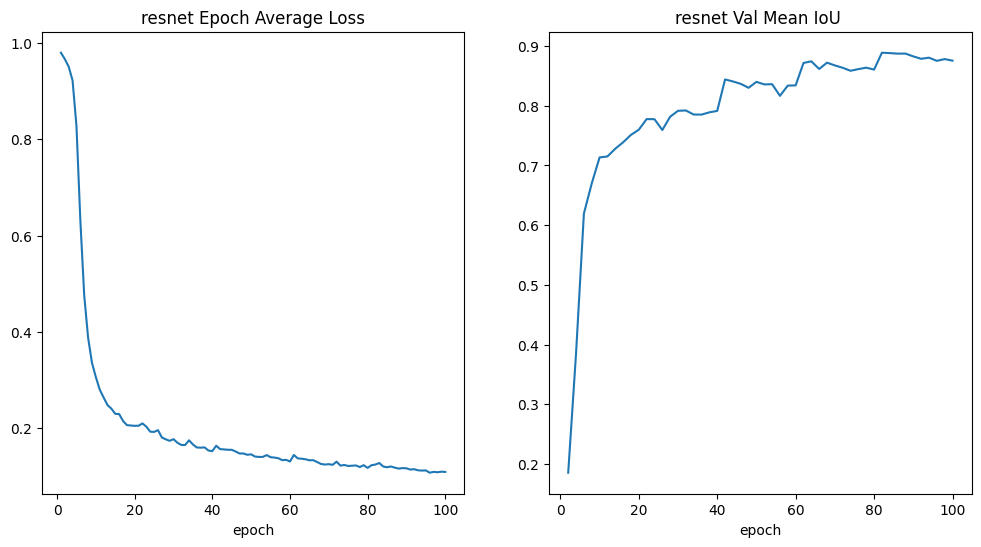

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


Total number of parameters: 7763041
----------
Fold 0
----------
epoch 1/100


Training: 100%|██████████| 97/97 [00:05<00:00, 17.77it/s]


epoch 1 average loss: 0.9735
----------
epoch 2/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.53it/s]


epoch 2 average loss: 0.9618


Validation: 100%|██████████| 97/97 [00:02<00:00, 45.82it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.1507
best mean IoU: 0.1507 at epoch: 2
----------
epoch 3/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.50it/s]


epoch 3 average loss: 0.9551
----------
epoch 4/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.11it/s]


epoch 4 average loss: 0.9474


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.45it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.1661
best mean IoU: 0.1661 at epoch: 4
----------
epoch 5/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.73it/s]


epoch 5 average loss: 0.9380
----------
epoch 6/100


Training: 100%|██████████| 97/97 [00:04<00:00, 24.05it/s]


epoch 6 average loss: 0.9252


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.29it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.1810
best mean IoU: 0.1810 at epoch: 6
----------
epoch 7/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.62it/s]


epoch 7 average loss: 0.9098
----------
epoch 8/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.87it/s]


epoch 8 average loss: 0.8904


Validation: 100%|██████████| 97/97 [00:01<00:00, 58.12it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.3809
best mean IoU: 0.3809 at epoch: 8
----------
epoch 9/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.01it/s]


epoch 9 average loss: 0.8601
----------
epoch 10/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.31it/s]


epoch 10 average loss: 0.8165


Validation: 100%|██████████| 97/97 [00:01<00:00, 58.61it/s]


saved new best metric model
current epoch: 10 current mean IoU: 0.6609
best mean IoU: 0.6609 at epoch: 10
----------
epoch 11/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.17it/s]


epoch 11 average loss: 0.7526
----------
epoch 12/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.58it/s]


epoch 12 average loss: 0.6826


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.67it/s]


current epoch: 12 current mean IoU: 0.6568
best mean IoU: 0.6609 at epoch: 10
----------
epoch 13/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.78it/s]


epoch 13 average loss: 0.6147
----------
epoch 14/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.83it/s]


epoch 14 average loss: 0.5424


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.64it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.7167
best mean IoU: 0.7167 at epoch: 14
----------
epoch 15/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.90it/s]


epoch 15 average loss: 0.4805
----------
epoch 16/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.52it/s]


epoch 16 average loss: 0.4267


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.94it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.7301
best mean IoU: 0.7301 at epoch: 16
----------
epoch 17/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.44it/s]


epoch 17 average loss: 0.3788
----------
epoch 18/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.27it/s]


epoch 18 average loss: 0.3466


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.44it/s]


saved new best metric model
current epoch: 18 current mean IoU: 0.7536
best mean IoU: 0.7536 at epoch: 18
----------
epoch 19/100


Training: 100%|██████████| 97/97 [00:04<00:00, 24.04it/s]


epoch 19 average loss: 0.3068
----------
epoch 20/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.72it/s]


epoch 20 average loss: 0.2862


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.40it/s]


saved new best metric model
current epoch: 20 current mean IoU: 0.7598
best mean IoU: 0.7598 at epoch: 20
----------
Fold 1
----------
epoch 21/100


Training: 100%|██████████| 97/97 [00:04<00:00, 20.47it/s]


epoch 21 average loss: 0.2768
----------
epoch 22/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.58it/s]


epoch 22 average loss: 0.2598


Validation: 100%|██████████| 97/97 [00:01<00:00, 50.54it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.7649
best mean IoU: 0.7649 at epoch: 22
----------
epoch 23/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.52it/s]


epoch 23 average loss: 0.2445
----------
epoch 24/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.95it/s]


epoch 24 average loss: 0.2348


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.60it/s]


saved new best metric model
current epoch: 24 current mean IoU: 0.7937
best mean IoU: 0.7937 at epoch: 24
----------
epoch 25/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.13it/s]


epoch 25 average loss: 0.2186
----------
epoch 26/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.77it/s]


epoch 26 average loss: 0.2124


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.03it/s]


saved new best metric model
current epoch: 26 current mean IoU: 0.8026
best mean IoU: 0.8026 at epoch: 26
----------
epoch 27/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.92it/s]


epoch 27 average loss: 0.2025
----------
epoch 28/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.32it/s]


epoch 28 average loss: 0.1999


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.25it/s]


current epoch: 28 current mean IoU: 0.8003
best mean IoU: 0.8026 at epoch: 26
----------
epoch 29/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.69it/s]


epoch 29 average loss: 0.1905
----------
epoch 30/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.40it/s]


epoch 30 average loss: 0.1806


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.40it/s]


saved new best metric model
current epoch: 30 current mean IoU: 0.8029
best mean IoU: 0.8029 at epoch: 30
----------
epoch 31/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.28it/s]


epoch 31 average loss: 0.1750
----------
epoch 32/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.21it/s]


epoch 32 average loss: 0.1735


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.61it/s]


current epoch: 32 current mean IoU: 0.7859
best mean IoU: 0.8029 at epoch: 30
----------
epoch 33/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.93it/s]


epoch 33 average loss: 0.1713
----------
epoch 34/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.74it/s]


epoch 34 average loss: 0.1647


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.53it/s]


saved new best metric model
current epoch: 34 current mean IoU: 0.8035
best mean IoU: 0.8035 at epoch: 34
----------
epoch 35/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.22it/s]


epoch 35 average loss: 0.1616
----------
epoch 36/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.31it/s]


epoch 36 average loss: 0.1544


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.56it/s]


saved new best metric model
current epoch: 36 current mean IoU: 0.8105
best mean IoU: 0.8105 at epoch: 36
----------
epoch 37/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.41it/s]


epoch 37 average loss: 0.1581
----------
epoch 38/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.96it/s]


epoch 38 average loss: 0.1512


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.14it/s]


current epoch: 38 current mean IoU: 0.8093
best mean IoU: 0.8105 at epoch: 36
----------
epoch 39/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.47it/s]


epoch 39 average loss: 0.1508
----------
epoch 40/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.45it/s]


epoch 40 average loss: 0.1458


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.64it/s]


current epoch: 40 current mean IoU: 0.8048
best mean IoU: 0.8105 at epoch: 36
----------
Fold 2
----------
epoch 41/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.77it/s]


epoch 41 average loss: 0.1581
----------
epoch 42/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.86it/s]


epoch 42 average loss: 0.1600


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.87it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.8577
best mean IoU: 0.8577 at epoch: 42
----------
epoch 43/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.83it/s]


epoch 43 average loss: 0.1540
----------
epoch 44/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.44it/s]


epoch 44 average loss: 0.1475


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.14it/s]


saved new best metric model
current epoch: 44 current mean IoU: 0.8587
best mean IoU: 0.8587 at epoch: 44
----------
epoch 45/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.14it/s]


epoch 45 average loss: 0.1435
----------
epoch 46/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.56it/s]


epoch 46 average loss: 0.1415


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.98it/s]


current epoch: 46 current mean IoU: 0.8568
best mean IoU: 0.8587 at epoch: 44
----------
epoch 47/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.34it/s]


epoch 47 average loss: 0.1426
----------
epoch 48/100


Training: 100%|██████████| 97/97 [00:04<00:00, 24.06it/s]


epoch 48 average loss: 0.1410


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.97it/s]


current epoch: 48 current mean IoU: 0.8560
best mean IoU: 0.8587 at epoch: 44
----------
epoch 49/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.54it/s]


epoch 49 average loss: 0.1347
----------
epoch 50/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.24it/s]


epoch 50 average loss: 0.1353


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.40it/s]


saved new best metric model
current epoch: 50 current mean IoU: 0.8594
best mean IoU: 0.8594 at epoch: 50
----------
epoch 51/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.22it/s]


epoch 51 average loss: 0.1307
----------
epoch 52/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.50it/s]


epoch 52 average loss: 0.1297


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.82it/s]


current epoch: 52 current mean IoU: 0.8538
best mean IoU: 0.8594 at epoch: 50
----------
epoch 53/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.66it/s]


epoch 53 average loss: 0.1281
----------
epoch 54/100


Training: 100%|██████████| 97/97 [00:04<00:00, 24.14it/s]


epoch 54 average loss: 0.1251


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.08it/s]


current epoch: 54 current mean IoU: 0.8582
best mean IoU: 0.8594 at epoch: 50
----------
epoch 55/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.91it/s]


epoch 55 average loss: 0.1260
----------
epoch 56/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.55it/s]


epoch 56 average loss: 0.1235


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.24it/s]


current epoch: 56 current mean IoU: 0.8492
best mean IoU: 0.8594 at epoch: 50
----------
epoch 57/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.90it/s]


epoch 57 average loss: 0.1229
----------
epoch 58/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.49it/s]


epoch 58 average loss: 0.1198


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.73it/s]


current epoch: 58 current mean IoU: 0.8528
best mean IoU: 0.8594 at epoch: 50
----------
epoch 59/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.11it/s]


epoch 59 average loss: 0.1218
----------
epoch 60/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.65it/s]


epoch 60 average loss: 0.1211


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.67it/s]


current epoch: 60 current mean IoU: 0.8543
best mean IoU: 0.8594 at epoch: 50
----------
Fold 3
----------
epoch 61/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.61it/s]


epoch 61 average loss: 0.1258
----------
epoch 62/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.43it/s]


epoch 62 average loss: 0.1268


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.69it/s]


saved new best metric model
current epoch: 62 current mean IoU: 0.8924
best mean IoU: 0.8924 at epoch: 62
----------
epoch 63/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.47it/s]


epoch 63 average loss: 0.1229
----------
epoch 64/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.16it/s]


epoch 64 average loss: 0.1172


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.68it/s]


saved new best metric model
current epoch: 64 current mean IoU: 0.8950
best mean IoU: 0.8950 at epoch: 64
----------
epoch 65/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.41it/s]


epoch 65 average loss: 0.1159
----------
epoch 66/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.49it/s]


epoch 66 average loss: 0.1155


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.02it/s]


current epoch: 66 current mean IoU: 0.8898
best mean IoU: 0.8950 at epoch: 64
----------
epoch 67/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.55it/s]


epoch 67 average loss: 0.1211
----------
epoch 68/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.92it/s]


epoch 68 average loss: 0.1169


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.04it/s]


current epoch: 68 current mean IoU: 0.8875
best mean IoU: 0.8950 at epoch: 64
----------
epoch 69/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.62it/s]


epoch 69 average loss: 0.1156
----------
epoch 70/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.74it/s]


epoch 70 average loss: 0.1122


Validation: 100%|██████████| 97/97 [00:01<00:00, 58.20it/s]


current epoch: 70 current mean IoU: 0.8862
best mean IoU: 0.8950 at epoch: 64
----------
epoch 71/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.46it/s]


epoch 71 average loss: 0.1105
----------
epoch 72/100


Training: 100%|██████████| 97/97 [00:04<00:00, 24.19it/s]


epoch 72 average loss: 0.1092


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.73it/s]


current epoch: 72 current mean IoU: 0.8860
best mean IoU: 0.8950 at epoch: 64
----------
epoch 73/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.67it/s]


epoch 73 average loss: 0.1080
----------
epoch 74/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.48it/s]


epoch 74 average loss: 0.1071


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.55it/s]


current epoch: 74 current mean IoU: 0.8863
best mean IoU: 0.8950 at epoch: 64
----------
epoch 75/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.87it/s]


epoch 75 average loss: 0.1082
----------
epoch 76/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.72it/s]


epoch 76 average loss: 0.1051


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.52it/s]


current epoch: 76 current mean IoU: 0.8798
best mean IoU: 0.8950 at epoch: 64
----------
epoch 77/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.98it/s]


epoch 77 average loss: 0.1076
----------
epoch 78/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.98it/s]


epoch 78 average loss: 0.1046


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.14it/s]


current epoch: 78 current mean IoU: 0.8796
best mean IoU: 0.8950 at epoch: 64
----------
epoch 79/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.70it/s]


epoch 79 average loss: 0.1062
----------
epoch 80/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.89it/s]


epoch 80 average loss: 0.1034


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.02it/s]


current epoch: 80 current mean IoU: 0.8794
best mean IoU: 0.8950 at epoch: 64
----------
Fold 4
----------
epoch 81/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.43it/s]


epoch 81 average loss: 0.1106
----------
epoch 82/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.54it/s]


epoch 82 average loss: 0.1114


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.46it/s]


saved new best metric model
current epoch: 82 current mean IoU: 0.9061
best mean IoU: 0.9061 at epoch: 82
----------
epoch 83/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.09it/s]


epoch 83 average loss: 0.1077
----------
epoch 84/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.53it/s]


epoch 84 average loss: 0.1044


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.92it/s]


saved new best metric model
current epoch: 84 current mean IoU: 0.9064
best mean IoU: 0.9064 at epoch: 84
----------
epoch 85/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.81it/s]


epoch 85 average loss: 0.1070
----------
epoch 86/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.46it/s]


epoch 86 average loss: 0.1028


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.66it/s]


current epoch: 86 current mean IoU: 0.9017
best mean IoU: 0.9064 at epoch: 84
----------
epoch 87/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.38it/s]


epoch 87 average loss: 0.0998
----------
epoch 88/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.20it/s]


epoch 88 average loss: 0.1035


Validation: 100%|██████████| 97/97 [00:01<00:00, 58.08it/s]


current epoch: 88 current mean IoU: 0.9019
best mean IoU: 0.9064 at epoch: 84
----------
epoch 89/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.51it/s]


epoch 89 average loss: 0.1010
----------
epoch 90/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.63it/s]


epoch 90 average loss: 0.0999


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.65it/s]


current epoch: 90 current mean IoU: 0.9017
best mean IoU: 0.9064 at epoch: 84
----------
epoch 91/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.54it/s]


epoch 91 average loss: 0.0999
----------
epoch 92/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.54it/s]


epoch 92 average loss: 0.0991


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.25it/s]


current epoch: 92 current mean IoU: 0.9023
best mean IoU: 0.9064 at epoch: 84
----------
epoch 93/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.59it/s]


epoch 93 average loss: 0.0989
----------
epoch 94/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.82it/s]


epoch 94 average loss: 0.0979


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.22it/s]


current epoch: 94 current mean IoU: 0.8938
best mean IoU: 0.9064 at epoch: 84
----------
epoch 95/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.05it/s]


epoch 95 average loss: 0.0972
----------
epoch 96/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.87it/s]


epoch 96 average loss: 0.0935


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.40it/s]


current epoch: 96 current mean IoU: 0.9007
best mean IoU: 0.9064 at epoch: 84
----------
epoch 97/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.50it/s]


epoch 97 average loss: 0.0932
----------
epoch 98/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.03it/s]


epoch 98 average loss: 0.0914


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.70it/s]


current epoch: 98 current mean IoU: 0.8962
best mean IoU: 0.9064 at epoch: 84
----------
epoch 99/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.52it/s]


epoch 99 average loss: 0.0898
----------
epoch 100/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.38it/s]


epoch 100 average loss: 0.0944


Validation: 100%|██████████| 97/97 [00:01<00:00, 57.67it/s]


current epoch: 100 current mean IoU: 0.8963
best mean IoU: 0.9064 at epoch: 84


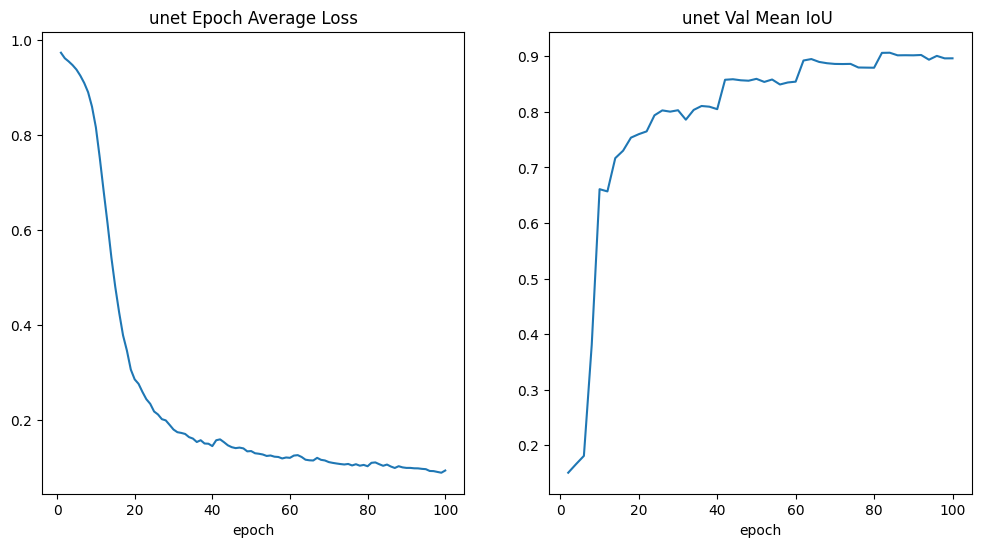

config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total number of parameters: 3714401
----------
Fold 0
----------
epoch 1/100


Training: 100%|██████████| 97/97 [00:10<00:00,  9.69it/s]


epoch 1 average loss: 0.9753
----------
epoch 2/100


Training: 100%|██████████| 97/97 [00:08<00:00, 12.09it/s]


epoch 2 average loss: 0.9368


Validation: 100%|██████████| 97/97 [00:04<00:00, 23.89it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.2824
best mean IoU: 0.2824 at epoch: 2
----------
epoch 3/100


Training: 100%|██████████| 97/97 [00:08<00:00, 12.01it/s]


epoch 3 average loss: 0.7988
----------
epoch 4/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.94it/s]


epoch 4 average loss: 0.6025


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.20it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.4995
best mean IoU: 0.4995 at epoch: 4
----------
epoch 5/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


epoch 5 average loss: 0.4808
----------
epoch 6/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.65it/s]


epoch 6 average loss: 0.4329


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.54it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.5823
best mean IoU: 0.5823 at epoch: 6
----------
epoch 7/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.79it/s]


epoch 7 average loss: 0.3910
----------
epoch 8/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.86it/s]


epoch 8 average loss: 0.3681


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.90it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.6311
best mean IoU: 0.6311 at epoch: 8
----------
epoch 9/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.77it/s]


epoch 9 average loss: 0.3545
----------
epoch 10/100


Training: 100%|██████████| 97/97 [00:08<00:00, 10.99it/s]


epoch 10 average loss: 0.3415


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.29it/s]


saved new best metric model
current epoch: 10 current mean IoU: 0.6347
best mean IoU: 0.6347 at epoch: 10
----------
epoch 11/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.60it/s]


epoch 11 average loss: 0.3295
----------
epoch 12/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.84it/s]


epoch 12 average loss: 0.3201


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.13it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.6436
best mean IoU: 0.6436 at epoch: 12
----------
epoch 13/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.71it/s]


epoch 13 average loss: 0.3170
----------
epoch 14/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.72it/s]


epoch 14 average loss: 0.3065


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.81it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.6475
best mean IoU: 0.6475 at epoch: 14
----------
epoch 15/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.51it/s]


epoch 15 average loss: 0.3079
----------
epoch 16/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.57it/s]


epoch 16 average loss: 0.3006


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.30it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.6662
best mean IoU: 0.6662 at epoch: 16
----------
epoch 17/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.83it/s]


epoch 17 average loss: 0.2935
----------
epoch 18/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


epoch 18 average loss: 0.2869


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.99it/s]


saved new best metric model
current epoch: 18 current mean IoU: 0.6712
best mean IoU: 0.6712 at epoch: 18
----------
epoch 19/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.50it/s]


epoch 19 average loss: 0.2899
----------
epoch 20/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.51it/s]


epoch 20 average loss: 0.2845


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.46it/s]


saved new best metric model
current epoch: 20 current mean IoU: 0.6730
best mean IoU: 0.6730 at epoch: 20
----------
Fold 1
----------
epoch 21/100


Training: 100%|██████████| 97/97 [00:09<00:00, 10.57it/s]


epoch 21 average loss: 0.2942
----------
epoch 22/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.89it/s]


epoch 22 average loss: 0.2849


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.03it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.7060
best mean IoU: 0.7060 at epoch: 22
----------
epoch 23/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.86it/s]


epoch 23 average loss: 0.2799
----------
epoch 24/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.79it/s]


epoch 24 average loss: 0.2844


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.34it/s]


current epoch: 24 current mean IoU: 0.6945
best mean IoU: 0.7060 at epoch: 22
----------
epoch 25/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.68it/s]


epoch 25 average loss: 0.2716
----------
epoch 26/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.90it/s]


epoch 26 average loss: 0.2691


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.24it/s]


current epoch: 26 current mean IoU: 0.7043
best mean IoU: 0.7060 at epoch: 22
----------
epoch 27/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.66it/s]


epoch 27 average loss: 0.2678
----------
epoch 28/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.60it/s]


epoch 28 average loss: 0.2569


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.71it/s]


current epoch: 28 current mean IoU: 0.7051
best mean IoU: 0.7060 at epoch: 22
----------
epoch 29/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.65it/s]


epoch 29 average loss: 0.2618
----------
epoch 30/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.91it/s]


epoch 30 average loss: 0.2529


Validation: 100%|██████████| 97/97 [00:03<00:00, 29.12it/s]


saved new best metric model
current epoch: 30 current mean IoU: 0.7104
best mean IoU: 0.7104 at epoch: 30
----------
epoch 31/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.61it/s]


epoch 31 average loss: 0.2554
----------
epoch 32/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


epoch 32 average loss: 0.2589


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.44it/s]


current epoch: 32 current mean IoU: 0.7048
best mean IoU: 0.7104 at epoch: 30
----------
epoch 33/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.50it/s]


epoch 33 average loss: 0.2584
----------
epoch 34/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.73it/s]


epoch 34 average loss: 0.2500


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.24it/s]


saved new best metric model
current epoch: 34 current mean IoU: 0.7118
best mean IoU: 0.7118 at epoch: 34
----------
epoch 35/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.84it/s]


epoch 35 average loss: 0.2601
----------
epoch 36/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.84it/s]


epoch 36 average loss: 0.2529


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.10it/s]


current epoch: 36 current mean IoU: 0.7089
best mean IoU: 0.7118 at epoch: 34
----------
epoch 37/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


epoch 37 average loss: 0.2473
----------
epoch 38/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.72it/s]


epoch 38 average loss: 0.2453


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.35it/s]


saved new best metric model
current epoch: 38 current mean IoU: 0.7137
best mean IoU: 0.7137 at epoch: 38
----------
epoch 39/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.48it/s]


epoch 39 average loss: 0.2435
----------
epoch 40/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.58it/s]


epoch 40 average loss: 0.2409


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.82it/s]


current epoch: 40 current mean IoU: 0.7120
best mean IoU: 0.7137 at epoch: 38
----------
Fold 2
----------
epoch 41/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.62it/s]


epoch 41 average loss: 0.2482
----------
epoch 42/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.43it/s]


epoch 42 average loss: 0.2450


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.45it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.7573
best mean IoU: 0.7573 at epoch: 42
----------
epoch 43/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.79it/s]


epoch 43 average loss: 0.2478
----------
epoch 44/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.86it/s]


epoch 44 average loss: 0.2449


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.59it/s]


saved new best metric model
current epoch: 44 current mean IoU: 0.7586
best mean IoU: 0.7586 at epoch: 44
----------
epoch 45/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.65it/s]


epoch 45 average loss: 0.2421
----------
epoch 46/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.91it/s]


epoch 46 average loss: 0.2418


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.71it/s]


current epoch: 46 current mean IoU: 0.7549
best mean IoU: 0.7586 at epoch: 44
----------
epoch 47/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


epoch 47 average loss: 0.2390
----------
epoch 48/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.51it/s]


epoch 48 average loss: 0.2371


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.81it/s]


current epoch: 48 current mean IoU: 0.7544
best mean IoU: 0.7586 at epoch: 44
----------
epoch 49/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.63it/s]


epoch 49 average loss: 0.2357
----------
epoch 50/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.80it/s]


epoch 50 average loss: 0.2344


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.91it/s]


current epoch: 50 current mean IoU: 0.7538
best mean IoU: 0.7586 at epoch: 44
----------
epoch 51/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


epoch 51 average loss: 0.2399
----------
epoch 52/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


epoch 52 average loss: 0.2355


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.71it/s]


current epoch: 52 current mean IoU: 0.7551
best mean IoU: 0.7586 at epoch: 44
----------
epoch 53/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.90it/s]


epoch 53 average loss: 0.2330
----------
epoch 54/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.72it/s]


epoch 54 average loss: 0.2293


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.77it/s]


current epoch: 54 current mean IoU: 0.7570
best mean IoU: 0.7586 at epoch: 44
----------
epoch 55/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


epoch 55 average loss: 0.2310
----------
epoch 56/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


epoch 56 average loss: 0.2291


Validation: 100%|██████████| 97/97 [00:03<00:00, 29.28it/s]


current epoch: 56 current mean IoU: 0.7560
best mean IoU: 0.7586 at epoch: 44
----------
epoch 57/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.77it/s]


epoch 57 average loss: 0.2293
----------
epoch 58/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


epoch 58 average loss: 0.2312


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.06it/s]


current epoch: 58 current mean IoU: 0.7530
best mean IoU: 0.7586 at epoch: 44
----------
epoch 59/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.87it/s]


epoch 59 average loss: 0.2262
----------
epoch 60/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.82it/s]


epoch 60 average loss: 0.2258


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.48it/s]


current epoch: 60 current mean IoU: 0.7548
best mean IoU: 0.7586 at epoch: 44
----------
Fold 3
----------
epoch 61/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.67it/s]


epoch 61 average loss: 0.2292
----------
epoch 62/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.59it/s]


epoch 62 average loss: 0.2296


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.84it/s]


saved new best metric model
current epoch: 62 current mean IoU: 0.7731
best mean IoU: 0.7731 at epoch: 62
----------
epoch 63/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.84it/s]


epoch 63 average loss: 0.2275
----------
epoch 64/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.88it/s]


epoch 64 average loss: 0.2273


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.90it/s]


saved new best metric model
current epoch: 64 current mean IoU: 0.7773
best mean IoU: 0.7773 at epoch: 64
----------
epoch 65/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.89it/s]


epoch 65 average loss: 0.2275
----------
epoch 66/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.70it/s]


epoch 66 average loss: 0.2360


Validation: 100%|██████████| 97/97 [00:03<00:00, 29.20it/s]


current epoch: 66 current mean IoU: 0.7668
best mean IoU: 0.7773 at epoch: 64
----------
epoch 67/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


epoch 67 average loss: 0.2257
----------
epoch 68/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.86it/s]


epoch 68 average loss: 0.2228


Validation: 100%|██████████| 97/97 [00:03<00:00, 29.01it/s]


current epoch: 68 current mean IoU: 0.7746
best mean IoU: 0.7773 at epoch: 64
----------
epoch 69/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.90it/s]


epoch 69 average loss: 0.2183
----------
epoch 70/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.95it/s]


epoch 70 average loss: 0.2191


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.12it/s]


current epoch: 70 current mean IoU: 0.7762
best mean IoU: 0.7773 at epoch: 64
----------
epoch 71/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


epoch 71 average loss: 0.2157
----------
epoch 72/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


epoch 72 average loss: 0.2196


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.37it/s]


current epoch: 72 current mean IoU: 0.7752
best mean IoU: 0.7773 at epoch: 64
----------
epoch 73/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.72it/s]


epoch 73 average loss: 0.2154
----------
epoch 74/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.81it/s]


epoch 74 average loss: 0.2162


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.91it/s]


current epoch: 74 current mean IoU: 0.7724
best mean IoU: 0.7773 at epoch: 64
----------
epoch 75/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.88it/s]


epoch 75 average loss: 0.2121
----------
epoch 76/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.84it/s]


epoch 76 average loss: 0.2114


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.50it/s]


current epoch: 76 current mean IoU: 0.7722
best mean IoU: 0.7773 at epoch: 64
----------
epoch 77/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.69it/s]


epoch 77 average loss: 0.2099
----------
epoch 78/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.71it/s]


epoch 78 average loss: 0.2102


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.32it/s]


current epoch: 78 current mean IoU: 0.7743
best mean IoU: 0.7773 at epoch: 64
----------
epoch 79/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.70it/s]


epoch 79 average loss: 0.2107
----------
epoch 80/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.82it/s]


epoch 80 average loss: 0.2119


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.65it/s]


current epoch: 80 current mean IoU: 0.7731
best mean IoU: 0.7773 at epoch: 64
----------
Fold 4
----------
epoch 81/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.79it/s]


epoch 81 average loss: 0.2139
----------
epoch 82/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.64it/s]


epoch 82 average loss: 0.2128


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.66it/s]


saved new best metric model
current epoch: 82 current mean IoU: 0.7851
best mean IoU: 0.7851 at epoch: 82
----------
epoch 83/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


epoch 83 average loss: 0.2151
----------
epoch 84/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


epoch 84 average loss: 0.2131


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.31it/s]


current epoch: 84 current mean IoU: 0.7835
best mean IoU: 0.7851 at epoch: 82
----------
epoch 85/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.67it/s]


epoch 85 average loss: 0.2096
----------
epoch 86/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.69it/s]


epoch 86 average loss: 0.2098


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.96it/s]


current epoch: 86 current mean IoU: 0.7824
best mean IoU: 0.7851 at epoch: 82
----------
epoch 87/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.66it/s]


epoch 87 average loss: 0.2063
----------
epoch 88/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


epoch 88 average loss: 0.2082


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.77it/s]


current epoch: 88 current mean IoU: 0.7812
best mean IoU: 0.7851 at epoch: 82
----------
epoch 89/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.66it/s]


epoch 89 average loss: 0.2095
----------
epoch 90/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.80it/s]


epoch 90 average loss: 0.2087


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.99it/s]


current epoch: 90 current mean IoU: 0.7812
best mean IoU: 0.7851 at epoch: 82
----------
epoch 91/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.65it/s]


epoch 91 average loss: 0.2093
----------
epoch 92/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.71it/s]


epoch 92 average loss: 0.2068


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.45it/s]


current epoch: 92 current mean IoU: 0.7794
best mean IoU: 0.7851 at epoch: 82
----------
epoch 93/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.61it/s]


epoch 93 average loss: 0.2030
----------
epoch 94/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.73it/s]


epoch 94 average loss: 0.2066


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.80it/s]


current epoch: 94 current mean IoU: 0.7812
best mean IoU: 0.7851 at epoch: 82
----------
epoch 95/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.70it/s]


epoch 95 average loss: 0.1997
----------
epoch 96/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.59it/s]


epoch 96 average loss: 0.2023


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.89it/s]


current epoch: 96 current mean IoU: 0.7804
best mean IoU: 0.7851 at epoch: 82
----------
epoch 97/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


epoch 97 average loss: 0.2049
----------
epoch 98/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.72it/s]


epoch 98 average loss: 0.2028


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.46it/s]


current epoch: 98 current mean IoU: 0.7799
best mean IoU: 0.7851 at epoch: 82
----------
epoch 99/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.89it/s]


epoch 99 average loss: 0.2014
----------
epoch 100/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.77it/s]


epoch 100 average loss: 0.2021


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.66it/s]


current epoch: 100 current mean IoU: 0.7750
best mean IoU: 0.7851 at epoch: 82


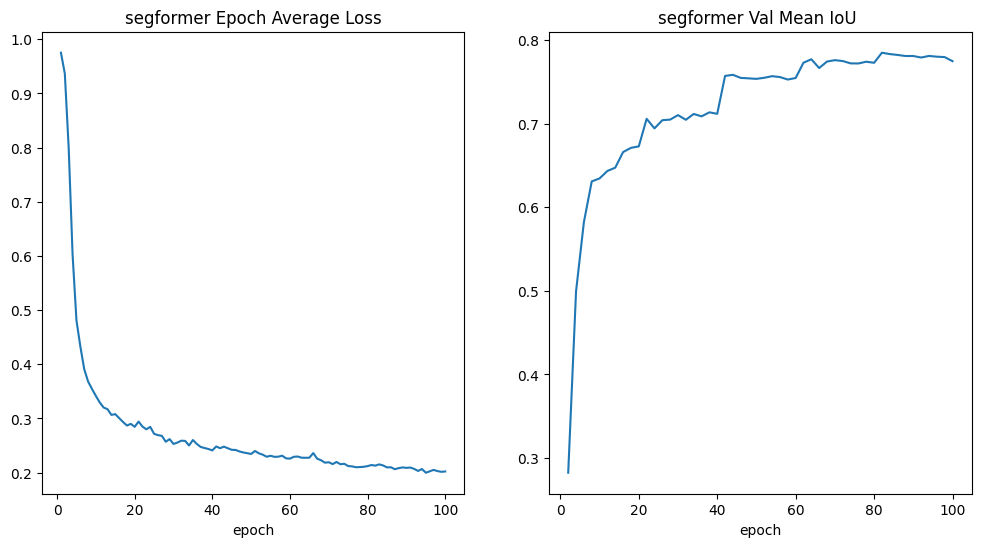

Total number of parameters: 51145311
----------
Fold 0
----------
epoch 1/100


Training: 100%|██████████| 97/97 [00:20<00:00,  4.68it/s]


epoch 1 average loss: 0.9550
----------
epoch 2/100


Training: 100%|██████████| 97/97 [00:12<00:00,  7.46it/s]


epoch 2 average loss: 0.8909


Validation: 100%|██████████| 97/97 [00:05<00:00, 17.91it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.2697
best mean IoU: 0.2697 at epoch: 2
----------
epoch 3/100


Training: 100%|██████████| 97/97 [00:12<00:00,  7.46it/s]


epoch 3 average loss: 0.7783
----------
epoch 4/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 4 average loss: 0.6306


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.17it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.5641
best mean IoU: 0.5641 at epoch: 4
----------
epoch 5/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.45it/s]


epoch 5 average loss: 0.4992
----------
epoch 6/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.45it/s]


epoch 6 average loss: 0.4384


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.10it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.6059
best mean IoU: 0.6059 at epoch: 6
----------
epoch 7/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 7 average loss: 0.3942
----------
epoch 8/100


Training: 100%|██████████| 97/97 [00:12<00:00,  7.47it/s]


epoch 8 average loss: 0.3584


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.33it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.6428
best mean IoU: 0.6428 at epoch: 8
----------
epoch 9/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 9 average loss: 0.3311
----------
epoch 10/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.39it/s]


epoch 10 average loss: 0.3089


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.27it/s]


saved new best metric model
current epoch: 10 current mean IoU: 0.6523
best mean IoU: 0.6523 at epoch: 10
----------
epoch 11/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 11 average loss: 0.2832
----------
epoch 12/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 12 average loss: 0.2757


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.71it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.6710
best mean IoU: 0.6710 at epoch: 12
----------
epoch 13/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 13 average loss: 0.2726
----------
epoch 14/100


Training: 100%|██████████| 97/97 [00:12<00:00,  7.47it/s]


epoch 14 average loss: 0.2627


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.29it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.6763
best mean IoU: 0.6763 at epoch: 14
----------
epoch 15/100


Training: 100%|██████████| 97/97 [00:12<00:00,  7.48it/s]


epoch 15 average loss: 0.2458
----------
epoch 16/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.45it/s]


epoch 16 average loss: 0.2419


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.08it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.6983
best mean IoU: 0.6983 at epoch: 16
----------
epoch 17/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 17 average loss: 0.2283
----------
epoch 18/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.46it/s]


epoch 18 average loss: 0.2273


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.09it/s]


current epoch: 18 current mean IoU: 0.6914
best mean IoU: 0.6983 at epoch: 16
----------
epoch 19/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 19 average loss: 0.2158
----------
epoch 20/100


Training: 100%|██████████| 97/97 [00:12<00:00,  7.46it/s]


epoch 20 average loss: 0.2061


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.06it/s]


saved new best metric model
current epoch: 20 current mean IoU: 0.7251
best mean IoU: 0.7251 at epoch: 20
----------
Fold 1
----------
epoch 21/100


Training: 100%|██████████| 97/97 [00:16<00:00,  5.90it/s]


epoch 21 average loss: 0.2203
----------
epoch 22/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.45it/s]


epoch 22 average loss: 0.2158


Validation: 100%|██████████| 97/97 [00:04<00:00, 19.46it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.7880
best mean IoU: 0.7880 at epoch: 22
----------
epoch 23/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 23 average loss: 0.2009
----------
epoch 24/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.38it/s]


epoch 24 average loss: 0.2007


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.75it/s]


current epoch: 24 current mean IoU: 0.7852
best mean IoU: 0.7880 at epoch: 22
----------
epoch 25/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 25 average loss: 0.1912
----------
epoch 26/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 26 average loss: 0.1835


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.20it/s]


saved new best metric model
current epoch: 26 current mean IoU: 0.7956
best mean IoU: 0.7956 at epoch: 26
----------
epoch 27/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.36it/s]


epoch 27 average loss: 0.1826
----------
epoch 28/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.39it/s]


epoch 28 average loss: 0.1779


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.93it/s]


current epoch: 28 current mean IoU: 0.7923
best mean IoU: 0.7956 at epoch: 26
----------
epoch 29/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 29 average loss: 0.1753
----------
epoch 30/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.44it/s]


epoch 30 average loss: 0.1695


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.09it/s]


current epoch: 30 current mean IoU: 0.7783
best mean IoU: 0.7956 at epoch: 26
----------
epoch 31/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.37it/s]


epoch 31 average loss: 0.1613
----------
epoch 32/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 32 average loss: 0.1597


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.23it/s]


current epoch: 32 current mean IoU: 0.7868
best mean IoU: 0.7956 at epoch: 26
----------
epoch 33/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.45it/s]


epoch 33 average loss: 0.1565
----------
epoch 34/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 34 average loss: 0.1570


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.02it/s]


current epoch: 34 current mean IoU: 0.7821
best mean IoU: 0.7956 at epoch: 26
----------
epoch 35/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.45it/s]


epoch 35 average loss: 0.1508
----------
epoch 36/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.37it/s]


epoch 36 average loss: 0.1414


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.80it/s]


current epoch: 36 current mean IoU: 0.7909
best mean IoU: 0.7956 at epoch: 26
----------
epoch 37/100


Training: 100%|██████████| 97/97 [00:12<00:00,  7.46it/s]


epoch 37 average loss: 0.1383
----------
epoch 38/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.46it/s]


epoch 38 average loss: 0.1352


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.61it/s]


current epoch: 38 current mean IoU: 0.7907
best mean IoU: 0.7956 at epoch: 26
----------
epoch 39/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.44it/s]


epoch 39 average loss: 0.1424
----------
epoch 40/100


Training: 100%|██████████| 97/97 [00:12<00:00,  7.48it/s]


epoch 40 average loss: 0.1344


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.02it/s]


current epoch: 40 current mean IoU: 0.7864
best mean IoU: 0.7956 at epoch: 26
----------
Fold 2
----------
epoch 41/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 41 average loss: 0.1525
----------
epoch 42/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 42 average loss: 0.1435


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.21it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.8786
best mean IoU: 0.8786 at epoch: 42
----------
epoch 43/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 43 average loss: 0.1441
----------
epoch 44/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.39it/s]


epoch 44 average loss: 0.1389


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.00it/s]


current epoch: 44 current mean IoU: 0.8778
best mean IoU: 0.8786 at epoch: 42
----------
epoch 45/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.35it/s]


epoch 45 average loss: 0.1353
----------
epoch 46/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 46 average loss: 0.1417


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.08it/s]


current epoch: 46 current mean IoU: 0.8460
best mean IoU: 0.8786 at epoch: 42
----------
epoch 47/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 47 average loss: 0.1375
----------
epoch 48/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 48 average loss: 0.1319


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.76it/s]


current epoch: 48 current mean IoU: 0.8702
best mean IoU: 0.8786 at epoch: 42
----------
epoch 49/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.39it/s]


epoch 49 average loss: 0.1251
----------
epoch 50/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.45it/s]


epoch 50 average loss: 0.1240


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.28it/s]


current epoch: 50 current mean IoU: 0.8663
best mean IoU: 0.8786 at epoch: 42
----------
epoch 51/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 51 average loss: 0.1189
----------
epoch 52/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.44it/s]


epoch 52 average loss: 0.1189


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.08it/s]


current epoch: 52 current mean IoU: 0.8642
best mean IoU: 0.8786 at epoch: 42
----------
epoch 53/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.44it/s]


epoch 53 average loss: 0.1187
----------
epoch 54/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.34it/s]


epoch 54 average loss: 0.1136


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.92it/s]


current epoch: 54 current mean IoU: 0.8626
best mean IoU: 0.8786 at epoch: 42
----------
epoch 55/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.44it/s]


epoch 55 average loss: 0.1157
----------
epoch 56/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 56 average loss: 0.1139


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.26it/s]


current epoch: 56 current mean IoU: 0.8602
best mean IoU: 0.8786 at epoch: 42
----------
epoch 57/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 57 average loss: 0.1146
----------
epoch 58/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 58 average loss: 0.1149


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.89it/s]


current epoch: 58 current mean IoU: 0.8505
best mean IoU: 0.8786 at epoch: 42
----------
epoch 59/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 59 average loss: 0.1112
----------
epoch 60/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 60 average loss: 0.1115


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.11it/s]


current epoch: 60 current mean IoU: 0.8497
best mean IoU: 0.8786 at epoch: 42
----------
Fold 3
----------
epoch 61/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 61 average loss: 0.1225
----------
epoch 62/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.39it/s]


epoch 62 average loss: 0.1121


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.83it/s]


saved new best metric model
current epoch: 62 current mean IoU: 0.9207
best mean IoU: 0.9207 at epoch: 62
----------
epoch 63/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 63 average loss: 0.1125
----------
epoch 64/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 64 average loss: 0.1114


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.18it/s]


current epoch: 64 current mean IoU: 0.9158
best mean IoU: 0.9207 at epoch: 62
----------
epoch 65/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.38it/s]


epoch 65 average loss: 0.1059
----------
epoch 66/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.36it/s]


epoch 66 average loss: 0.1027


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.84it/s]


current epoch: 66 current mean IoU: 0.9147
best mean IoU: 0.9207 at epoch: 62
----------
epoch 67/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 67 average loss: 0.1030
----------
epoch 68/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 68 average loss: 0.0995


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.49it/s]


current epoch: 68 current mean IoU: 0.9101
best mean IoU: 0.9207 at epoch: 62
----------
epoch 69/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 69 average loss: 0.1019
----------
epoch 70/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 70 average loss: 0.1032


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.29it/s]


current epoch: 70 current mean IoU: 0.9070
best mean IoU: 0.9207 at epoch: 62
----------
epoch 71/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.39it/s]


epoch 71 average loss: 0.0987
----------
epoch 72/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.38it/s]


epoch 72 average loss: 0.0961


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.11it/s]


current epoch: 72 current mean IoU: 0.9066
best mean IoU: 0.9207 at epoch: 62
----------
epoch 73/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 73 average loss: 0.0983
----------
epoch 74/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 74 average loss: 0.0962


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.92it/s]


current epoch: 74 current mean IoU: 0.9028
best mean IoU: 0.9207 at epoch: 62
----------
epoch 75/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 75 average loss: 0.0968
----------
epoch 76/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.39it/s]


epoch 76 average loss: 0.0910


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.31it/s]


current epoch: 76 current mean IoU: 0.9007
best mean IoU: 0.9207 at epoch: 62
----------
epoch 77/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 77 average loss: 0.0881
----------
epoch 78/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.39it/s]


epoch 78 average loss: 0.0907


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.80it/s]


current epoch: 78 current mean IoU: 0.8937
best mean IoU: 0.9207 at epoch: 62
----------
epoch 79/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.38it/s]


epoch 79 average loss: 0.0893
----------
epoch 80/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 80 average loss: 0.0883


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.09it/s]


current epoch: 80 current mean IoU: 0.8957
best mean IoU: 0.9207 at epoch: 62
----------
Fold 4
----------
epoch 81/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 81 average loss: 0.0999
----------
epoch 82/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 82 average loss: 0.0936


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.75it/s]


saved new best metric model
current epoch: 82 current mean IoU: 0.9386
best mean IoU: 0.9386 at epoch: 82
----------
epoch 83/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.41it/s]


epoch 83 average loss: 0.0953
----------
epoch 84/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 84 average loss: 0.0943


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.01it/s]


current epoch: 84 current mean IoU: 0.9351
best mean IoU: 0.9386 at epoch: 82
----------
epoch 85/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.38it/s]


epoch 85 average loss: 0.0899
----------
epoch 86/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.43it/s]


epoch 86 average loss: 0.0927


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.02it/s]


current epoch: 86 current mean IoU: 0.9300
best mean IoU: 0.9386 at epoch: 82
----------
epoch 87/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.44it/s]


epoch 87 average loss: 0.0905
----------
epoch 88/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.39it/s]


epoch 88 average loss: 0.0868


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.78it/s]


current epoch: 88 current mean IoU: 0.9304
best mean IoU: 0.9386 at epoch: 82
----------
epoch 89/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.38it/s]


epoch 89 average loss: 0.0859
----------
epoch 90/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 90 average loss: 0.0892


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.81it/s]


current epoch: 90 current mean IoU: 0.9243
best mean IoU: 0.9386 at epoch: 82
----------
epoch 91/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 91 average loss: 0.0892
----------
epoch 92/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.44it/s]


epoch 92 average loss: 0.0889


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.07it/s]


current epoch: 92 current mean IoU: 0.9282
best mean IoU: 0.9386 at epoch: 82
----------
epoch 93/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.42it/s]


epoch 93 average loss: 0.0841
----------
epoch 94/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.45it/s]


epoch 94 average loss: 0.0828


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.73it/s]


current epoch: 94 current mean IoU: 0.9194
best mean IoU: 0.9386 at epoch: 82
----------
epoch 95/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 95 average loss: 0.0819
----------
epoch 96/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.45it/s]


epoch 96 average loss: 0.0816


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.95it/s]


current epoch: 96 current mean IoU: 0.9232
best mean IoU: 0.9386 at epoch: 82
----------
epoch 97/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 97 average loss: 0.0820
----------
epoch 98/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 98 average loss: 0.0796


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.74it/s]


current epoch: 98 current mean IoU: 0.9194
best mean IoU: 0.9386 at epoch: 82
----------
epoch 99/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.37it/s]


epoch 99 average loss: 0.0777
----------
epoch 100/100


Training: 100%|██████████| 97/97 [00:13<00:00,  7.40it/s]


epoch 100 average loss: 0.0775


Validation: 100%|██████████| 97/97 [00:04<00:00, 20.94it/s]


current epoch: 100 current mean IoU: 0.9175
best mean IoU: 0.9386 at epoch: 82


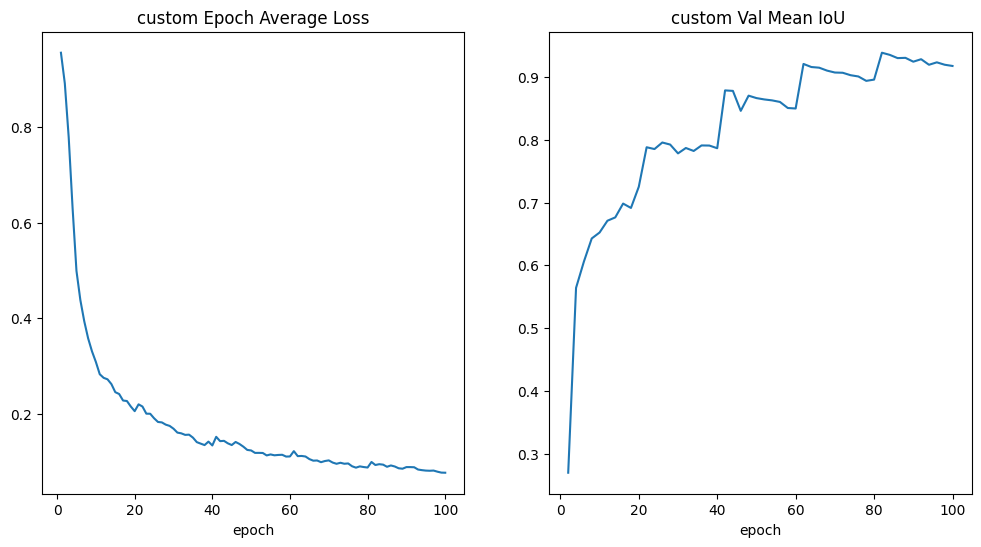

In [27]:
for model_type in model_list:
    os.makedirs(os.path.join(root_dir, model_type), exist_ok=True)
    out_dir = os.path.join(root_dir, model_type)
    loss_values, metric_values = train_model(model_type, df_model_par, out_dir, loss_function, metric, device, lr=1e-4, attention_gate_flag=True)
    plot_train_curve(loss_values, metric_values, model_type, out_dir)

Testing

In [53]:
test_loader = DataLoader(
    test_set, batch_size=8, num_workers=4
)
out_dir

'/content/drive/MyDrive/Stroke_Segmentation/custom'

In [30]:
root_dir

'/content/drive/MyDrive/'

In [36]:
model_list = ["resnet", "unet", "segformer", "custom"]

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


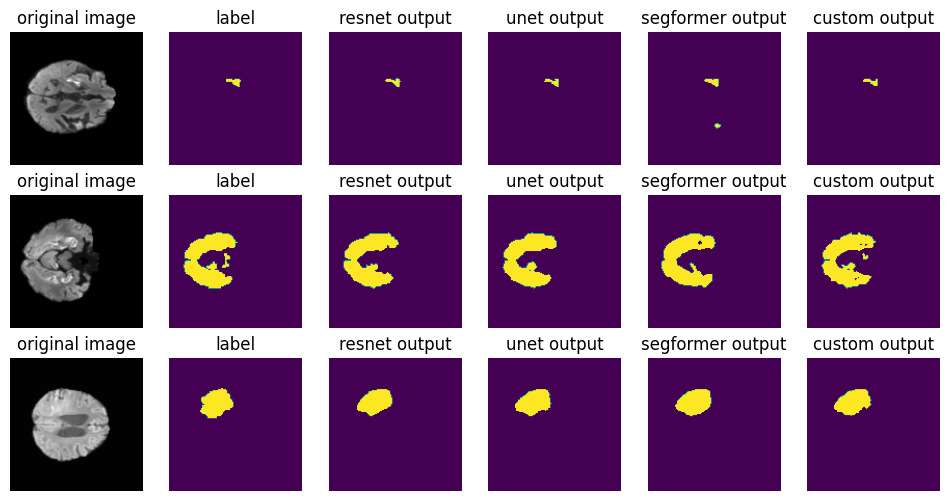

In [37]:
mean_test_metric = pd.DataFrame(columns=['model_tye', 'mean_test_iou'])
plt.figure("check", (12, 6))
for j in range(len(model_list)):
    model_type = model_list[j]
    model = get_model(model_type, device, attention_gate_flag=True)
    model.load_state_dict(torch.load(os.path.join(root_dir, model_type, "best_metric_model.pth")))
    model.eval()
    test_metric_values = []
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):

            test_outputs = model(test_data["image"].to(device))
            test_labels = test_data["label"].to(device)
            if model_type == "segformer":
                test_outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(test_outputs.logits,128,mode="bilinear",align_corners=False))

            test_outputs = test_outputs.float() > 0.5
            iou = metric(test_outputs, test_labels)
            test_metric_values.append(iou.item())


            # for j in range(10):
            if i >= 30 and i < 33:
                k = i - 30
                if j == 0:
                    plt.subplot(3, 6, 1 + 6 * k)
                    plt.title("original image")
                    plt.axis("off")
                    plt.imshow(test_data["image"][5, 0, :, :], cmap="gray")
                    plt.subplot(3, 6, 2 + 6 * k)
                    plt.title("label")
                    plt.axis("off")
                    plt.imshow(test_data["label"][5, 0, :, :])
                plt.subplot(3, 6, j + 3 + 6 * k)
                plt.title(f"{model_type} output")
                plt.axis("off")

                plt.imshow(test_outputs.detach().cpu()[5, 0, :, :])
    mean_test_metric.loc[j] = [model_type, sum(test_metric_values) / len(test_metric_values)]
plt.savefig(os.path.join(root_dir, f"model_comparison.png"))
plt.show()


In [38]:
mean_test_metric

,model_tye,mean_test_iou
0,resnet,0.767503
1,unet,0.786753
2,segformer,0.698115
3,custom,0.764607


In [39]:
df_model_par['parameters_num_millions'] = df_model_par['parameters_num'] / 1_000_000

In [40]:
df_model_par

,model_type,parameters_num,parameters_num_millions
0,resnet,24436369,24.436369
1,unet,7763041,7.763041
2,segformer,3714401,3.714401
3,custom,51145311,51.145311


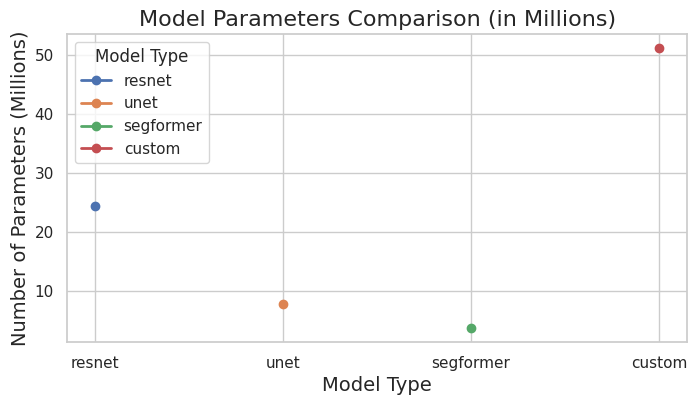

In [41]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
for idx, row in df_model_par.iterrows():
    plt.plot([row['model_type']], [row['parameters_num_millions']], label=row['model_type'], marker='o', linestyle='-', linewidth=2)
plt.title('Model Parameters Comparison (in Millions)', fontsize=16)
plt.xlabel('Model Type', fontsize=14)
plt.ylabel('Number of Parameters (Millions)', fontsize=14)
plt.legend(title='Model Type')
plt.savefig(os.path.join(root_dir, "model_parameters_line_plot.png"), dpi=300)
plt.show()

In [155]:
# # Assuming 'model' is your model instance
model = get_model("custom", device, attention_gate_flag=True)

# print(model)


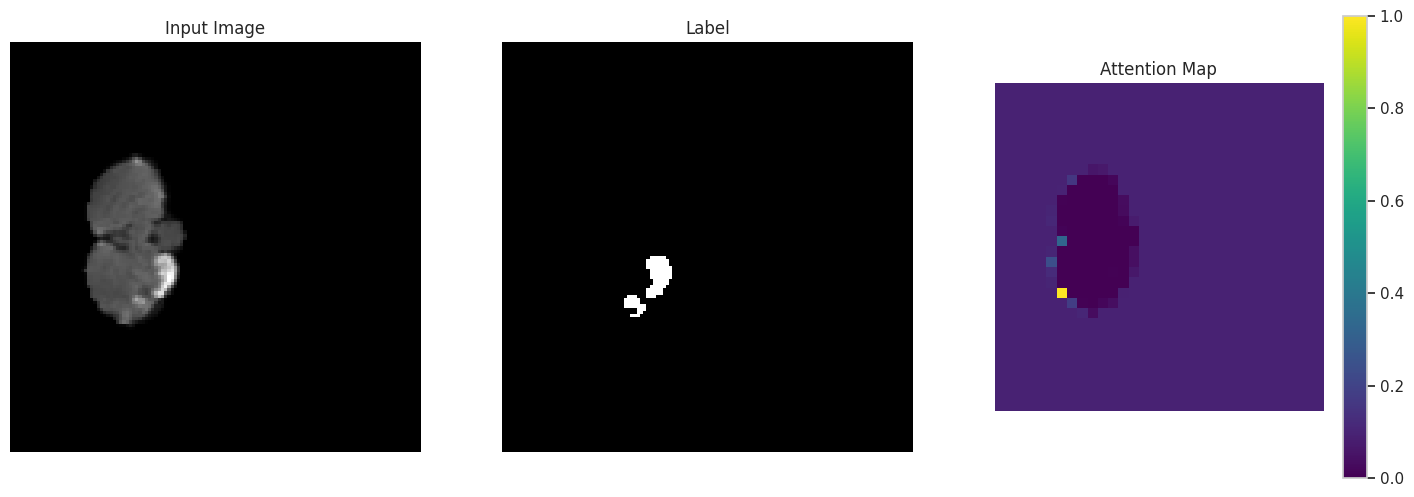

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Assuming 'model', 'test_loader', and 'device' are already defined and configured
model.eval()

# Function to attach a hook and capture attention weights
def attention_hook(module, input, output):
    global attention_weights
    # output is a tuple of (output, attn_weights), where attn_weights is what we need
    attention_weights = output[1].detach()  # Detach to avoid any gradient computation

# Attach the hook to the first self-attention block of the first transformer in the first encoder layer
handle = model.encoder.layers[0]['transformers'].blocks[0]['self-attention'].attention.register_forward_hook(attention_hook)

test_metric_values = []
plt.figure(figsize=(18, 6))  # Adjust the figure size as needed
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_outputs = model(test_data["image"].to(device))
        test_labels = test_data["label"].to(device)

        # Assuming you have a function `metric` that calculates IOU or another relevant metric
        iou = metric(test_outputs, test_labels)
        test_metric_values.append(iou.item())

        if i == 32:  # Visualize the results for one batch index to check the attention mechanism
            attention_map = attention_weights[0][0]  # First head's attention weights of the first example
            attention_map = attention_map.cpu()  # Move the attention map to CPU
            # Reshape the attention map to its square form if it's flat (assuming it's a square matrix)
            side_length = int(attention_map.shape[0] ** 0.5)
            attention_map = attention_map.view(side_length, side_length)
            attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

            img = test_data["image"][0].cpu().numpy().transpose(1, 2, 0)
            img = (img - img.min()) / (img.max() - img.min())  # Normalize image for displaying

            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Input Image")
            plt.axis("off")



            label_img = test_data["label"][0].cpu().numpy().squeeze()
            plt.subplot(1, 3, 2)
            plt.imshow(label_img, cmap='gray')
            plt.title("Label")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(attention_map.numpy(), cmap='viridis')
            plt.title("Attention Map")
            plt.colorbar()
            plt.axis("off")

plt.show()
handle.remove()  # Clean up the hook after use to prevent memory leak


In [157]:
# # # Assuming 'model' is your model instance
model = get_model("segformer", device, attention_gate_flag=True)
# Assuming 'model', 'test_loader', and 'device' are already defined and configured
# model.eval()
# print(model)
#

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


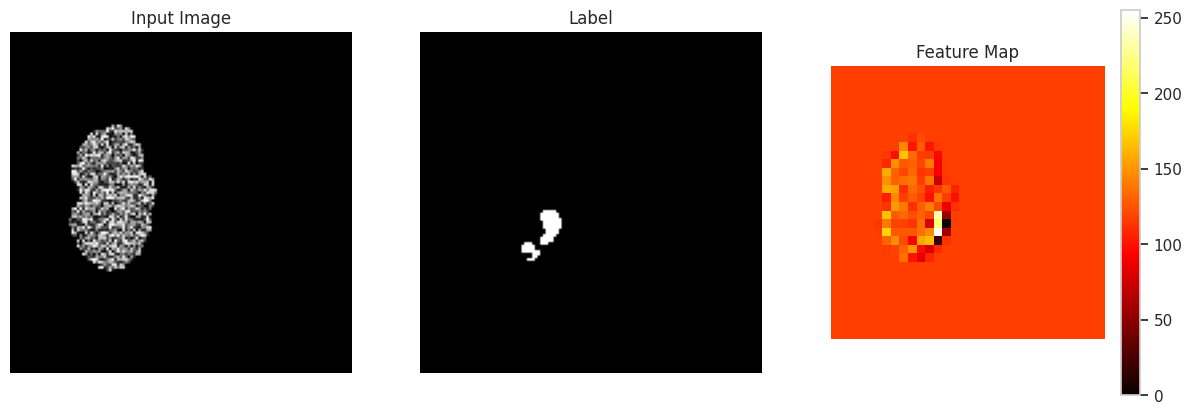

In [124]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Assuming 'model' and 'test_loader' are properly set up and 'device' is defined
model.eval()

# Function to attach a hook
feature_maps = []
def get_feature_maps(module, input, output):
    feature_maps.append(output.detach())  # Append the detached output of the layer

# Attach the hook to the desired layer
handle = model.segformer.encoder.patch_embeddings[0].proj.register_forward_hook(get_feature_maps)

# Prepare to visualize
plt.figure(figsize=(15, 5))

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i == 32:  # Assuming we visualize for the 30th batch
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = model(inputs)

            # Assuming the feature map is from the first image in the batch and visualizing the first feature map
            if feature_maps:
                feature_map = feature_maps[0][0, 0, :, :]  # Select the first feature map for the first image in the batch
                # Normalize feature map for better visualization
                feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

            # Convert to PIL images for visualization
            input_img = to_pil_image(inputs[0].cpu())
            label_img = to_pil_image(labels[0].float().cpu(), mode='L')
            feature_map_img = to_pil_image(feature_map.cpu(), mode='L')

            plt.subplot(1, 3, 1)
            plt.imshow(input_img)
            plt.title('Input Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(label_img, cmap='gray')
            plt.title('Label')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(feature_map_img, cmap='hot')
            plt.title('Feature Map')
            plt.colorbar()
            plt.axis('off')

            break  # We only visualize the first relevant batch

plt.show()

# Don't forget to remove the hook after visualization to clean up
handle.remove()


In [158]:
# # # Assuming 'model' is your model instance
# model_list = ["resnet", "unet", "segformer", "custom"]
model = get_model("unet", device, attention_gate_flag=True)
# Assuming 'model', 'test_loader', and 'device' are already defined and configured
# model.eval()
# print(model)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


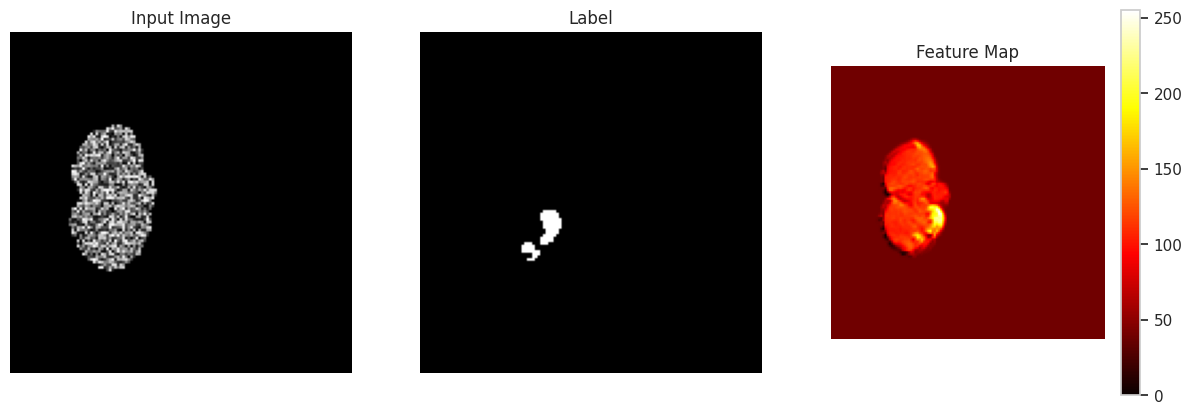

In [160]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Assuming 'model', 'test_loader', and 'device' are properly set up
model.eval()

# Function to attach a hook
feature_maps = []
def get_feature_maps(module, input, output):
    feature_maps.append(output)  # Append the output of the layer

# Attach the hook to the first convolutional layer of the first encoder block
handle = model.encoder1.enc1conv1.register_forward_hook(get_feature_maps)

# Setup the plot
plt.figure(figsize=(15, 5))

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i == 32:  # Visualize for the 30th batch
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = model(inputs)

            # Access the feature map
            if feature_maps:
                # Extract the first feature map from the first image in the batch
                feature_map = feature_maps[0][0, 0, :, :]
                feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

                # Convert to PIL image for visualization
                input_img = to_pil_image(inputs[0].cpu())
                label_img = to_pil_image(labels[0].float().cpu(), mode='L')
                feature_map_img = to_pil_image(feature_map.cpu(), mode='L')

                # Plotting
                plt.subplot(1, 3, 1)
                plt.imshow(input_img)
                plt.title('Input Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(label_img, cmap='gray')
                plt.title('Label')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(feature_map_img, cmap='hot')
                plt.title('Feature Map')
                plt.colorbar()
                plt.axis('off')

            break  # Only visualize the first matching batch

plt.show()

# Remove the hook after visualization to clean up
handle.remove()  # Remove the hook


In [162]:
# model_list = ["resnet", "unet", "segformer", "custom"]
model = get_model("resnet", device, attention_gate_flag=True)
# Assuming 'model', 'test_loader', and 'device' are already defined and configured
# model.eval()
# print(model)

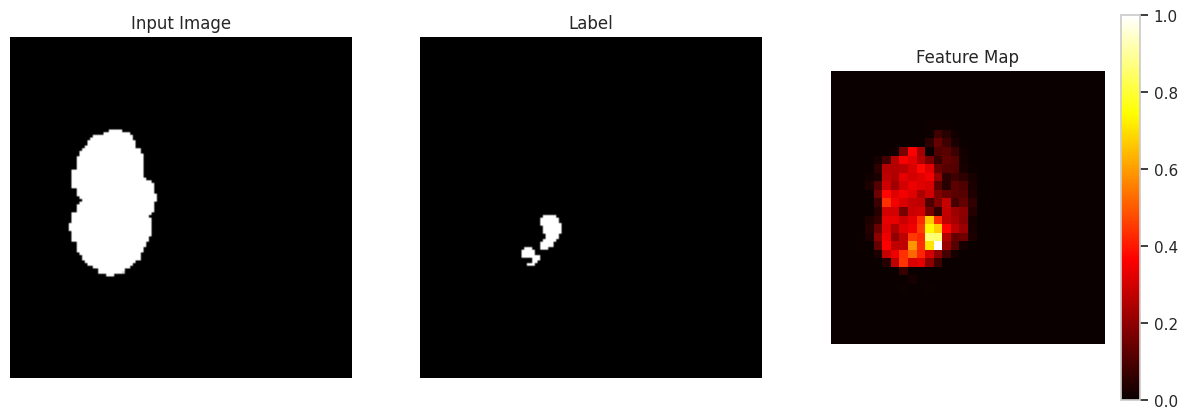

In [163]:
import torch
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Define a hook to capture the outputs of a specific layer
feature_maps = []
def hook(module, input, output):
    feature_maps.append(output.detach())

# Register the hook to the first BasicBlock after the first downsampling in layer1
handle = model.encoder.layer1[0].register_forward_hook(hook)

# Prepare the figure for plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Process a single batch from your data loader
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i == 32:  # Just an example to process a specific batch
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = model(inputs)

            # Check if feature maps are captured
            if feature_maps:
                # Select a feature map from the first item in the batch, for example, the first channel
                feature_map = feature_maps[0][0, 0, :, :]  # Adjust indices as needed
                # Normalize the feature map for better visualization
                feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

                # Plotting the input image
                ax[0].imshow(inputs.cpu().data[0].permute(1, 2, 0))
                ax[0].set_title("Input Image")
                ax[0].axis('off')

                # Plotting the label
                ax[1].imshow(labels.cpu().data[0].squeeze(), cmap='gray')
                ax[1].set_title("Label")
                ax[1].axis('off')

                # Plotting the feature map as a heatmap
                # ax[2].imshow(feature_map.cpu(), cmap='hot', interpolation='nearest')
                # ax[2].set_title("Feature Map")
                feature_map_image = ax[2].imshow(feature_map.cpu(), cmap='hot', interpolation='nearest')
                ax[2].set_title("Feature Map")
                ax[2].axis('off')
                plt.colorbar(feature_map_image, ax=ax[2], orientation='vertical')

                ax[2].axis('off')

                plt.show()
                break  # Stop after processing the specified batch

# Don't forget to remove the hook after you're done
handle.remove()
